<a href="https://colab.research.google.com/github/Prachi-Agr/Image-Denoising/blob/master/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10
from keras import backend as K

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(train_data, _), (test_data, _) = cifar10.load_data()


170500096/170498071 [==============================] - 6s 0us/step


In [3]:
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

In [4]:
def noise(data):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)    #Gaussian noise with mean 0 and standard deviation 0.1
    data = data + noise
    data = np.clip(data, 0., 1.)                                     #Pixel values clipped to 0-1 after adding noise
    return data

In [5]:
train_noise = noise(train_data)
test_noise = noise(test_data)

In [6]:
def denoise_autoencoder():
  input_img = Input(shape=(32, 32, 3))
  x = Conv2D(32, (3, 3), padding='same')(input_img)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(32, (3, 3), padding='same')(encoded)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(3, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  decoded = Activation('sigmoid')(x)
  return Model(input_img,decoded)

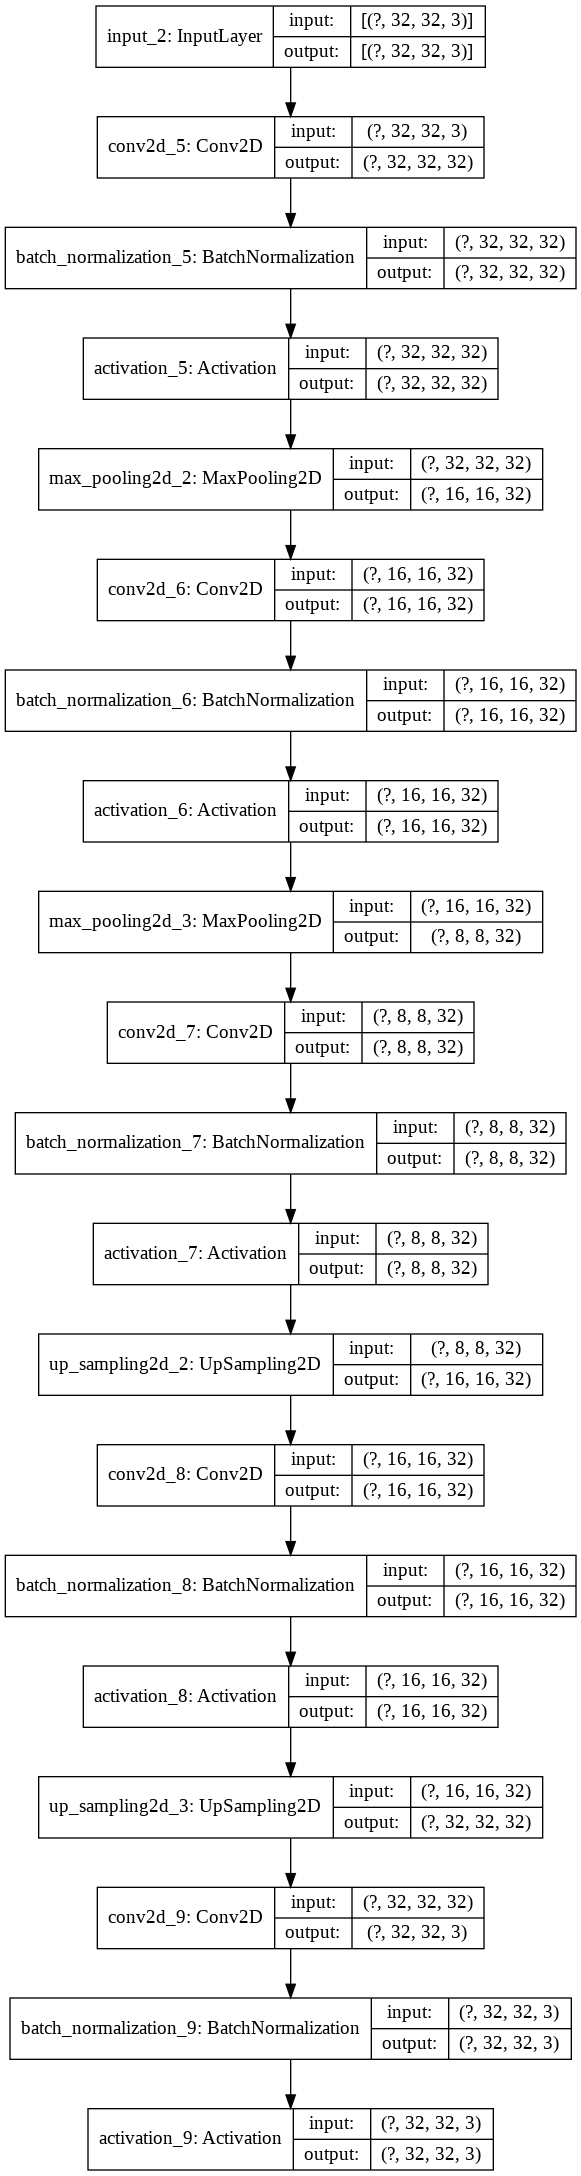

In [8]:
denoise=denoise_autoencoder()
import tensorflow
tensorflow.keras.utils.plot_model(denoise, to_file='model_denoise_autoencoder.png', show_shapes=True, show_layer_names=True)

In [9]:
denoise.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model_denoise.h5', verbose=1, save_best_only=True, save_weights_only=True)

denoise.fit(train_noise,train_data,validation_data=(test_noise, test_data),epochs=40,batch_size=100,callbacks=[checkpoint])

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 0.0094
Epoch 00001: val_loss improved from inf to 0.00677, saving model to best_model_denoise.h5
500/500 [==============================] - 5s 9ms/step - loss: 0.0094 - val_loss: 0.0068
Epoch 2/40
500/500 [==============================] - ETA: 0s - loss: 0.0055
Epoch 00002: val_loss improved from 0.00677 to 0.00504, saving model to best_model_denoise.h5
500/500 [==============================] - 4s 8ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 3/40
496/500 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00003: val_loss improved from 0.00504 to 0.00450, saving model to best_model_denoise.h5
500/500 [==============================] - 4s 9ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 4/40
498/500 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00004: val_loss improved from 0.00450 to 0.00393, saving model to best_model_denoise.h5
500/500 [==============================] - 4s 8ms/ste

In [11]:
denoise.load_weights('best_model_denoise.h5')
test_data_denoised = denoise.predict(test_noise)

In [12]:
def mse(d1, d2):
   return np.square(np.subtract(d1, d2)).mean()
noisy_orig_mse = mse(test_data, test_noise)             #MSE of noisy and original data
denoised_orig_mse = mse(test_data_denoised, test_data)  # MSE of noisy and denoise data

noisy_orig_mse, denoised_orig_mse

(0.009301587876863535, 0.002526932)

Autoencoder decreased the noise by around 72.8%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future ve

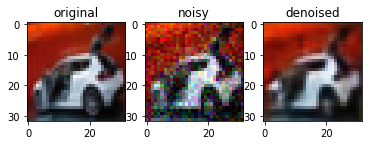

In [13]:
for i in range(7):
  plt.subplot(1,3,1)
  plt.imshow(test_data[i])
  plt.title('original')
  plt.subplot(1,3,2)
  plt.imshow(test_noise[i])
  plt.title('noisy')
  plt.subplot(1,3,3)
  plt.imshow(test_data_denoised[i])
  plt.title('denoised')
  plt.savefig('%d.png'%i)